### 仅在 `colab` 上有效

In [1]:
!gdown '1-Ex3ssVpwPibjGzB9QTeMCcsRvZ9yceK'

/usr/bin/sh: 1: gdown: not found


### 设置超参数

In [2]:
IMG_SIZE = 625
BATCH_SIZE = 2
EPOCHS = 1000
NUM_KEYPOINTS = 4 * 2  # 4 pairs each having x and y coordinates

### 准备数据集

In [3]:
!rm -rf ./dataset
!unzip -oq dataset.zip
!rm -rf ./dataset/.git
!rm -rf ./dataset/.DS_Store
!rm -rf __MACOSX
!rm -rf ./resized
!mkdir ./resized

### 加载数据集，将数据集转换成如下格式的字典。

```json
{
  "image_path1" => [[
    627.6153846153846,
    872.6410256410256
  ], ...],
  "image_path2" => [...]
}
```

In [4]:
import os
import json
import pathlib
from PIL import Image
from matplotlib import pyplot as plt

json_dict = {}
for p in pathlib.Path('./dataset').glob('*'):
  plate = p.name  
  path = str(p)
  with open(f"{path}/{plate}.json") as file:
    os.mkdir(f"./resized/{plate}")

    normal_image_path = f"{path}/{plate}.jpg"
    resized_image_path = f"./resized/{plate}/{plate}.jpg"

    image = Image.open(normal_image_path)
    resized_image = image.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS)
    resized_image.save(resized_image_path)

    points = json.load(file)['shapes'][0]['points']
    for p in points:
      p[0] = p[0] / image.width * IMG_SIZE
      p[1] = p[1] / image.height * IMG_SIZE

    json_dict[resized_image_path] = points


### 根据 `key` 获取对应 `points`

In [5]:
# Utility for reading an image and for getting its annotations.
def get_dog(key):  
  data = { 'joints': json_dict[key] }
  img_data = plt.imread(key)
  # If the image is RGBA convert it to RGB.
  if img_data.shape[-1] == 4:
    img_data = img_data.astype(np.uint8)
    img_data = Image.fromarray(img_data)
    img_data = np.array(img_data.convert("RGB"))
  data['img_data'] = img_data
  return data

### 定义显示关键点方法

In [6]:
import numpy as np
from imgaug.augmentables.kps import KeypointsOnImage

def visualize_keypoints(images, keypoints):
    fig, axes = plt.subplots(nrows=len(images), ncols=2, figsize=(16, 12))
    [ax.axis("off") for ax in np.ravel(axes)]

    for (ax_orig, ax_all), image, current_keypoint in zip(axes, images, keypoints):
        ax_orig.imshow(image)
        ax_all.imshow(image)

        # If the keypoints were formed by `imgaug` then the coordinates need
        # to be iterated differently.
        if isinstance(current_keypoint, KeypointsOnImage):
            for idx, kp in enumerate(current_keypoint.keypoints):
                ax_all.scatter(
                    [kp.x], [kp.y], c='red', marker="x", s=50, linewidths=5
                )
        else:
            current_keypoint = np.array(current_keypoint)
            # Since the last entry is the visibility flag, we discard it.
            current_keypoint = current_keypoint[:, :2]
            for idx, (x, y) in enumerate(current_keypoint):
                ax_all.scatter([x], [y], c='red', marker="x", s=50, linewidths=5)

    plt.tight_layout(pad=2.0)
    plt.show()

### 检查一下数据

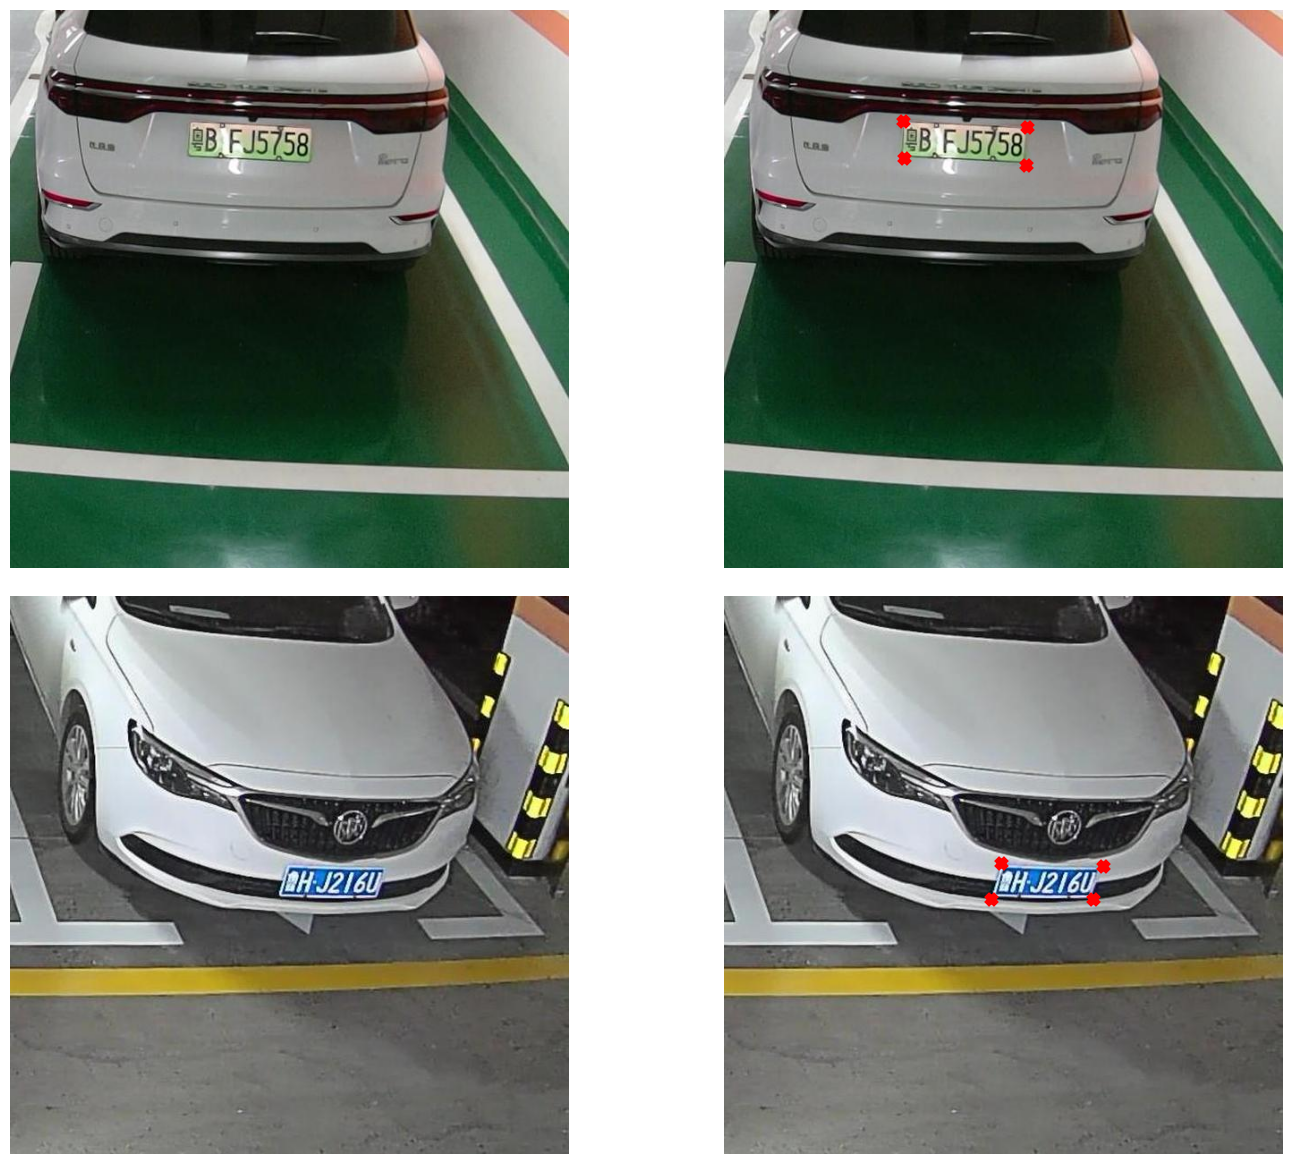

In [7]:
# 选取两个样本检查
samples = list(json_dict.keys())
num_samples = 2
selected_samples = np.random.choice(samples, num_samples, replace=False)

images, keypoints = [], []

for sample in selected_samples:
    data = get_dog(sample)
    images.append(data["img_data"])
    keypoints.append(data["joints"])

visualize_keypoints(images, keypoints)

### 构建数据生成器

In [8]:
from tensorflow import keras

class KeyPointsDataset(keras.utils.Sequence):
    def __init__(self, image_keys, aug, batch_size=BATCH_SIZE, train=True):
        self.image_keys = image_keys
        self.aug = aug
        self.batch_size = batch_size
        self.train = train
        self.on_epoch_end()

    def __len__(self):
        return len(self.image_keys) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_keys))
        if self.train:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        image_keys_temp = [self.image_keys[k] for k in indexes]
        (images, keypoints) = self.__data_generation(image_keys_temp)

        return (images, keypoints)

    def __data_generation(self, image_keys_temp):
        batch_images = np.empty((self.batch_size, IMG_SIZE, IMG_SIZE, 3), dtype="int")
        batch_keypoints = np.empty(
            (self.batch_size, 1, 1, NUM_KEYPOINTS), dtype="float32"
        )

        for i, key in enumerate(image_keys_temp):
            data = get_dog(key)
            current_keypoint = np.array(data["joints"])[:, :2]
            current_image = data["img_data"]
            batch_images[i,] = current_image

            kp_temp = []
            for keypoint in current_keypoint:
                kp_temp.append(np.nan_to_num(keypoint[0]))
                kp_temp.append(np.nan_to_num(keypoint[1]))

            # More on why this reshaping later.
            batch_keypoints[i,] = np.array(kp_temp).reshape(1, 1, 4 * 2)

        # Scale the coordinates to [0, 1] range.
        batch_keypoints = batch_keypoints / IMG_SIZE

        return (batch_images, batch_keypoints)

In [9]:
import imgaug.augmenters as iaa

train_aug = iaa.Sequential([])
test_aug = iaa.Sequential([])

### 准备训练集和验证集

In [10]:
np.random.shuffle(samples)
train_keys, validation_keys = (
    samples[int(len(samples) * 0.15) :],
    samples[: int(len(samples) * 0.15)],
)

### 检查训练集和验证集

Total batches in training set: 152
Total batches in validation set: 26


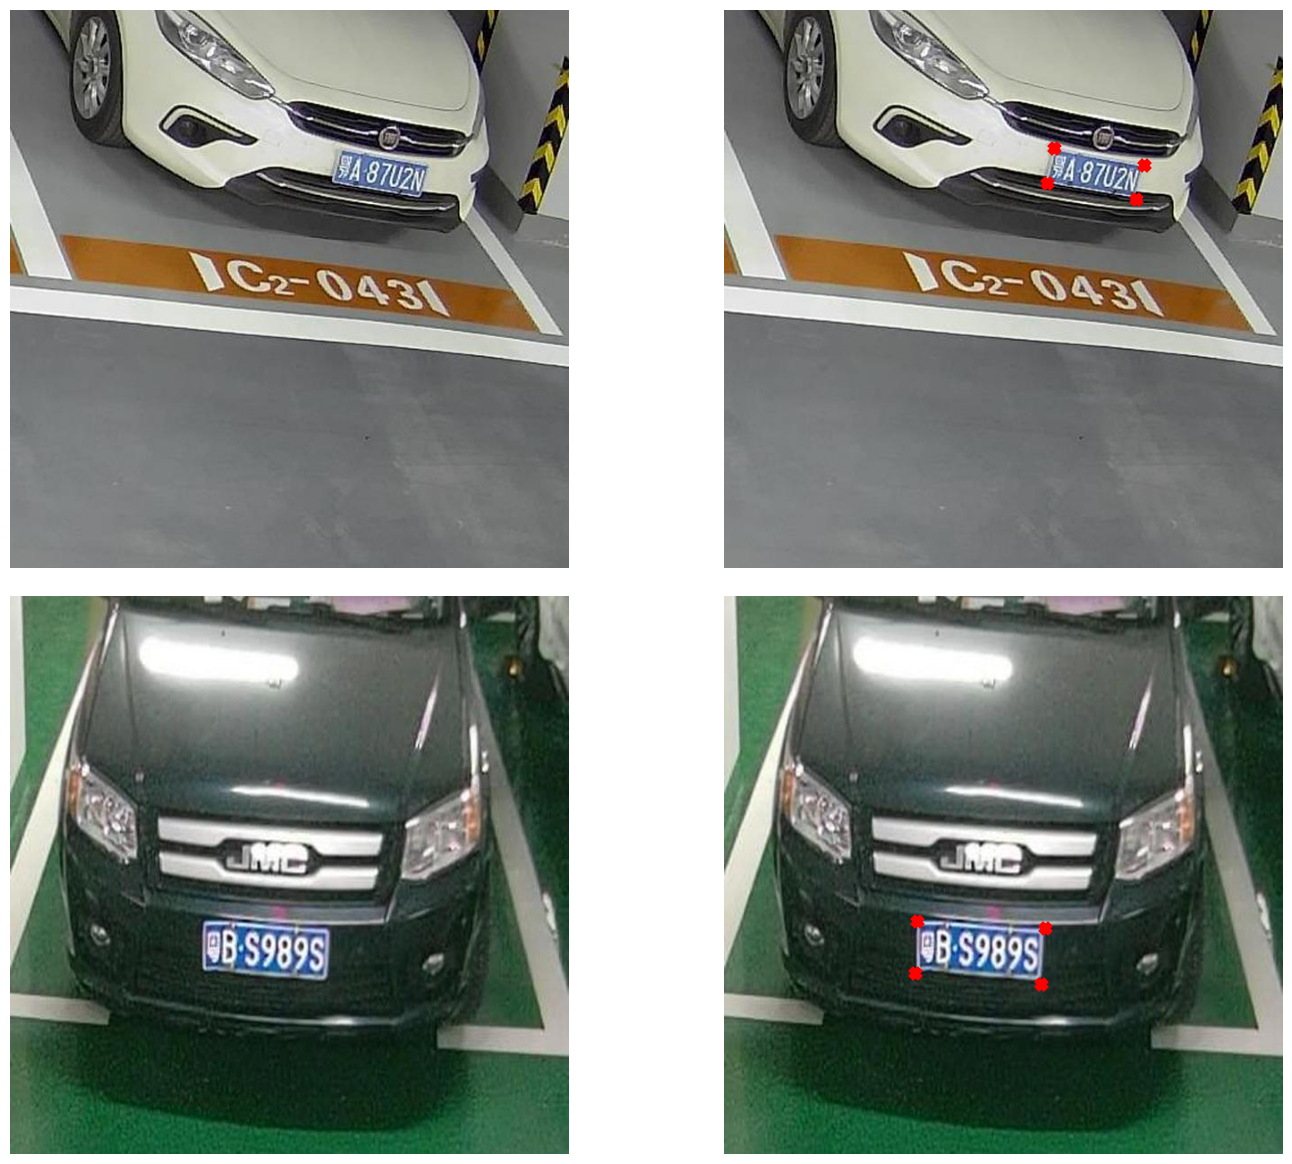

In [11]:
train_dataset = KeyPointsDataset(train_keys, train_aug)
validation_dataset = KeyPointsDataset(validation_keys, test_aug, train=False)

print(f"Total batches in training set: {len(train_dataset)}")
print(f"Total batches in validation set: {len(validation_dataset)}")

sample_images, sample_keypoints = next(iter(train_dataset))

sample_keypoints = sample_keypoints[:4].reshape(-1, 4, 2) * IMG_SIZE
visualize_keypoints(sample_images[:4], sample_keypoints)

### 构建模型

In [12]:
import tensorflow as tf

def get_model():
  inputs = keras.layers.Input((IMG_SIZE, IMG_SIZE, 3))
  x = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), strides=1, padding='same', activation='relu')(inputs)
  x = tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same', strides=2)(x)
  x = tf.keras.layers.Conv2D(filters=96, kernel_size=(3, 3), strides=1, padding='same', activation='relu')(x)
  x = tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same', strides=2)(x)  
  x = tf.keras.layers.Conv2D(filters=96, kernel_size=(3, 3), strides=1, padding='same', activation='relu')(x)
  x = tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same', strides=2)(x)    
  x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='relu')(x)
  x = tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same', strides=2)(x)    
  x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='relu')(x)
  x = tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same', strides=2)(x)       
  x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='relu')(x)
  x = tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same', strides=2)(x)         
  x = tf.keras.layers.SeparableConv2D(NUM_KEYPOINTS, kernel_size=5, strides=1, activation="relu")(x)
  x = tf.keras.layers.SeparableConv2D(NUM_KEYPOINTS, kernel_size=3, strides=1, activation="relu")(x)   
  x = tf.keras.layers.SeparableConv2D(NUM_KEYPOINTS, kernel_size=3, strides=1, activation="sigmoid")(x) 
  x = tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same', strides=2)(x) 
  return keras.models.Model(inputs=inputs, outputs=x) 

### 生成模型

In [13]:
model = get_model()
model.compile(loss="mse", optimizer=keras.optimizers.Adam(1e-4))
get_model().summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 625, 625, 3)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 625, 625, 128)     3584      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 313, 313, 128)    0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 313, 313, 96)      110688    
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 157, 157, 96)     0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 157, 157, 96)      8304

### 预览模型架构

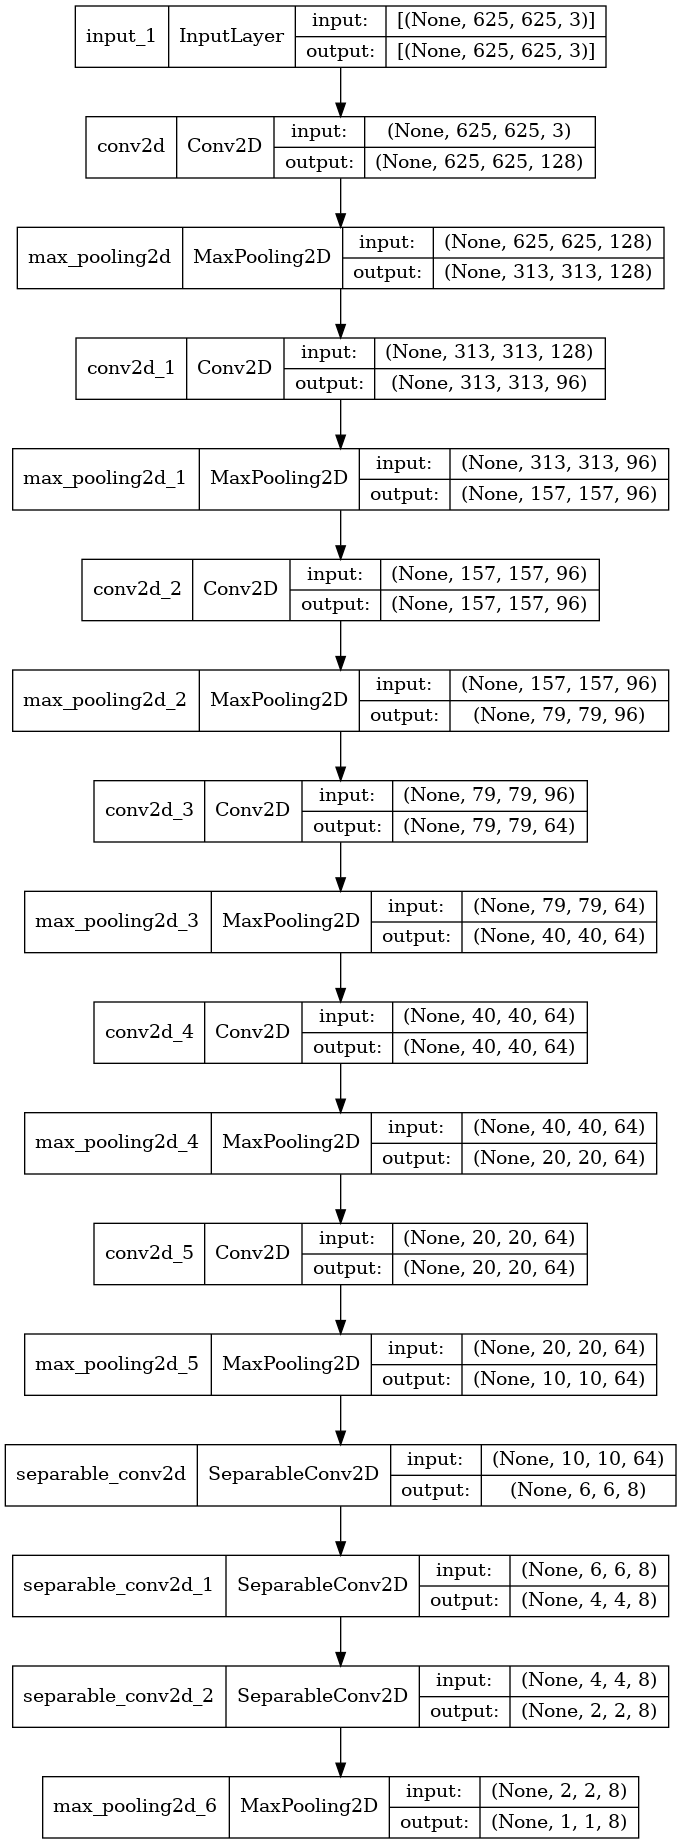

In [14]:
tf.keras.utils.plot_model(model, show_shapes=True)

### 训练

In [15]:
model.fit(train_dataset, validation_data=validation_dataset, epochs=EPOCHS)

Epoch 1/1000
152/152 [==============================] - 227s 1s/step - loss: 0.0215 - val_loss: 0.0154
Epoch 2/1000
152/152 [==============================] - 226s 1s/step - loss: 0.0190 - val_loss: 0.0146
Epoch 3/1000
152/152 [==============================] - 226s 1s/step - loss: 0.0179 - val_loss: 0.0144
Epoch 4/1000
152/152 [==============================] - 226s 1s/step - loss: 0.0166 - val_loss: 0.0131
Epoch 5/1000
152/152 [==============================] - 227s 1s/step - loss: 0.0152 - val_loss: 0.0133
Epoch 6/1000
152/152 [==============================] - 228s 1s/step - loss: 0.0136 - val_loss: 0.0139
Epoch 7/1000
152/152 [==============================] - 227s 1s/step - loss: 0.0126 - val_loss: 0.0120
Epoch 8/1000
152/152 [==============================] - 227s 1s/step - loss: 0.0110 - val_loss: 0.0109
Epoch 9/1000
152/152 [==============================] - 227s 1s/step - loss: 0.0092 - val_loss: 0.0105
Epoch 10/1000
152/152 [==============================] - 227s 1s/step - l

Epoch 79/1000
152/152 [==============================] - 227s 1s/step - loss: 5.5685e-04 - val_loss: 0.0083
Epoch 80/1000
152/152 [==============================] - 227s 1s/step - loss: 5.9869e-04 - val_loss: 0.0087
Epoch 81/1000
152/152 [==============================] - 227s 1s/step - loss: 5.9331e-04 - val_loss: 0.0077
Epoch 82/1000
152/152 [==============================] - 226s 1s/step - loss: 5.9621e-04 - val_loss: 0.0078
Epoch 83/1000
152/152 [==============================] - 226s 1s/step - loss: 6.8943e-04 - val_loss: 0.0081
Epoch 84/1000
152/152 [==============================] - 226s 1s/step - loss: 6.8370e-04 - val_loss: 0.0078
Epoch 85/1000
152/152 [==============================] - 226s 1s/step - loss: 6.0472e-04 - val_loss: 0.0076
Epoch 86/1000
152/152 [==============================] - 226s 1s/step - loss: 6.1289e-04 - val_loss: 0.0083
Epoch 87/1000
152/152 [==============================] - 226s 1s/step - loss: 5.9995e-04 - val_loss: 0.0080
Epoch 88/1000
152/152 [=====

152/152 [==============================] - 223s 1s/step - loss: 3.3928e-04 - val_loss: 0.0074
Epoch 155/1000
152/152 [==============================] - 223s 1s/step - loss: 2.8191e-04 - val_loss: 0.0073
Epoch 156/1000
152/152 [==============================] - 223s 1s/step - loss: 2.4395e-04 - val_loss: 0.0070
Epoch 157/1000
152/152 [==============================] - 223s 1s/step - loss: 2.2837e-04 - val_loss: 0.0074
Epoch 158/1000
152/152 [==============================] - 223s 1s/step - loss: 2.6268e-04 - val_loss: 0.0077
Epoch 159/1000
152/152 [==============================] - 223s 1s/step - loss: 3.0854e-04 - val_loss: 0.0075
Epoch 160/1000
152/152 [==============================] - 223s 1s/step - loss: 3.1352e-04 - val_loss: 0.0068
Epoch 161/1000
152/152 [==============================] - 223s 1s/step - loss: 3.7794e-04 - val_loss: 0.0072
Epoch 162/1000
152/152 [==============================] - 222s 1s/step - loss: 3.5366e-04 - val_loss: 0.0073
Epoch 163/1000
152/152 [==========

152/152 [==============================] - 221s 1s/step - loss: 2.0811e-04 - val_loss: 0.0069
Epoch 230/1000
152/152 [==============================] - 221s 1s/step - loss: 1.9324e-04 - val_loss: 0.0071
Epoch 231/1000
152/152 [==============================] - 222s 1s/step - loss: 1.7638e-04 - val_loss: 0.0067
Epoch 232/1000
152/152 [==============================] - 222s 1s/step - loss: 1.8070e-04 - val_loss: 0.0070
Epoch 233/1000
152/152 [==============================] - 221s 1s/step - loss: 1.8178e-04 - val_loss: 0.0070
Epoch 234/1000
152/152 [==============================] - 222s 1s/step - loss: 2.1711e-04 - val_loss: 0.0063
Epoch 235/1000
152/152 [==============================] - 221s 1s/step - loss: 2.4217e-04 - val_loss: 0.0069
Epoch 236/1000
152/152 [==============================] - 221s 1s/step - loss: 2.1353e-04 - val_loss: 0.0067
Epoch 237/1000
152/152 [==============================] - 221s 1s/step - loss: 2.1031e-04 - val_loss: 0.0069
Epoch 238/1000
152/152 [==========

152/152 [==============================] - 221s 1s/step - loss: 1.1967e-04 - val_loss: 0.0066
Epoch 305/1000
152/152 [==============================] - 221s 1s/step - loss: 1.2127e-04 - val_loss: 0.0066
Epoch 306/1000
152/152 [==============================] - 220s 1s/step - loss: 1.3990e-04 - val_loss: 0.0062
Epoch 307/1000
152/152 [==============================] - 220s 1s/step - loss: 1.5726e-04 - val_loss: 0.0066
Epoch 308/1000
152/152 [==============================] - 220s 1s/step - loss: 1.6110e-04 - val_loss: 0.0068
Epoch 309/1000
152/152 [==============================] - 220s 1s/step - loss: 1.9947e-04 - val_loss: 0.0067
Epoch 310/1000
152/152 [==============================] - 221s 1s/step - loss: 1.7797e-04 - val_loss: 0.0066
Epoch 311/1000
152/152 [==============================] - 221s 1s/step - loss: 1.5820e-04 - val_loss: 0.0065
Epoch 312/1000
152/152 [==============================] - 220s 1s/step - loss: 1.4189e-04 - val_loss: 0.0067
Epoch 313/1000
152/152 [==========

152/152 [==============================] - 219s 1s/step - loss: 1.2047e-04 - val_loss: 0.0067
Epoch 380/1000
152/152 [==============================] - 220s 1s/step - loss: 1.5878e-04 - val_loss: 0.0068
Epoch 381/1000
152/152 [==============================] - 219s 1s/step - loss: 1.4288e-04 - val_loss: 0.0066
Epoch 382/1000
152/152 [==============================] - 220s 1s/step - loss: 1.5072e-04 - val_loss: 0.0070
Epoch 383/1000
152/152 [==============================] - 220s 1s/step - loss: 1.3957e-04 - val_loss: 0.0064
Epoch 384/1000
152/152 [==============================] - 220s 1s/step - loss: 1.5207e-04 - val_loss: 0.0064
Epoch 385/1000
152/152 [==============================] - 220s 1s/step - loss: 1.2020e-04 - val_loss: 0.0064
Epoch 386/1000
152/152 [==============================] - 220s 1s/step - loss: 1.0725e-04 - val_loss: 0.0066
Epoch 387/1000
152/152 [==============================] - 219s 1s/step - loss: 9.1888e-05 - val_loss: 0.0065
Epoch 388/1000
152/152 [==========

152/152 [==============================] - 219s 1s/step - loss: 1.2150e-04 - val_loss: 0.0062
Epoch 455/1000
152/152 [==============================] - 219s 1s/step - loss: 1.1541e-04 - val_loss: 0.0059
Epoch 456/1000
152/152 [==============================] - 219s 1s/step - loss: 1.0374e-04 - val_loss: 0.0061
Epoch 457/1000
152/152 [==============================] - 219s 1s/step - loss: 9.3068e-05 - val_loss: 0.0062
Epoch 458/1000
152/152 [==============================] - 219s 1s/step - loss: 8.8787e-05 - val_loss: 0.0063
Epoch 459/1000
152/152 [==============================] - 219s 1s/step - loss: 8.3675e-05 - val_loss: 0.0066
Epoch 460/1000
152/152 [==============================] - 219s 1s/step - loss: 8.3904e-05 - val_loss: 0.0059
Epoch 461/1000
152/152 [==============================] - 219s 1s/step - loss: 9.9814e-05 - val_loss: 0.0062
Epoch 462/1000
152/152 [==============================] - 219s 1s/step - loss: 8.9275e-05 - val_loss: 0.0063
Epoch 463/1000
152/152 [==========

152/152 [==============================] - 218s 1s/step - loss: 7.7096e-05 - val_loss: 0.0060
Epoch 530/1000
152/152 [==============================] - 218s 1s/step - loss: 7.1928e-05 - val_loss: 0.0061
Epoch 531/1000
152/152 [==============================] - 218s 1s/step - loss: 7.0617e-05 - val_loss: 0.0063
Epoch 532/1000
152/152 [==============================] - 218s 1s/step - loss: 9.3176e-05 - val_loss: 0.0063
Epoch 533/1000
152/152 [==============================] - 219s 1s/step - loss: 8.8452e-05 - val_loss: 0.0063
Epoch 534/1000
152/152 [==============================] - 218s 1s/step - loss: 8.3443e-05 - val_loss: 0.0062
Epoch 535/1000
152/152 [==============================] - 218s 1s/step - loss: 8.9047e-05 - val_loss: 0.0060
Epoch 536/1000
152/152 [==============================] - 218s 1s/step - loss: 8.5799e-05 - val_loss: 0.0061
Epoch 537/1000
152/152 [==============================] - 218s 1s/step - loss: 1.0026e-04 - val_loss: 0.0061
Epoch 538/1000
152/152 [==========

152/152 [==============================] - 219s 1s/step - loss: 7.5071e-05 - val_loss: 0.0061
Epoch 605/1000
152/152 [==============================] - 219s 1s/step - loss: 7.0845e-05 - val_loss: 0.0060
Epoch 606/1000
152/152 [==============================] - 219s 1s/step - loss: 6.4111e-05 - val_loss: 0.0058
Epoch 607/1000
152/152 [==============================] - 219s 1s/step - loss: 8.2576e-05 - val_loss: 0.0058
Epoch 608/1000
152/152 [==============================] - 218s 1s/step - loss: 8.7215e-05 - val_loss: 0.0061
Epoch 609/1000
152/152 [==============================] - 218s 1s/step - loss: 7.8674e-05 - val_loss: 0.0062
Epoch 610/1000
152/152 [==============================] - 219s 1s/step - loss: 7.2329e-05 - val_loss: 0.0059
Epoch 611/1000
152/152 [==============================] - 219s 1s/step - loss: 6.8487e-05 - val_loss: 0.0061
Epoch 612/1000
152/152 [==============================] - 219s 1s/step - loss: 6.3351e-05 - val_loss: 0.0061
Epoch 613/1000
152/152 [==========

KeyboardInterrupt: 

### 显示训练结果

实际


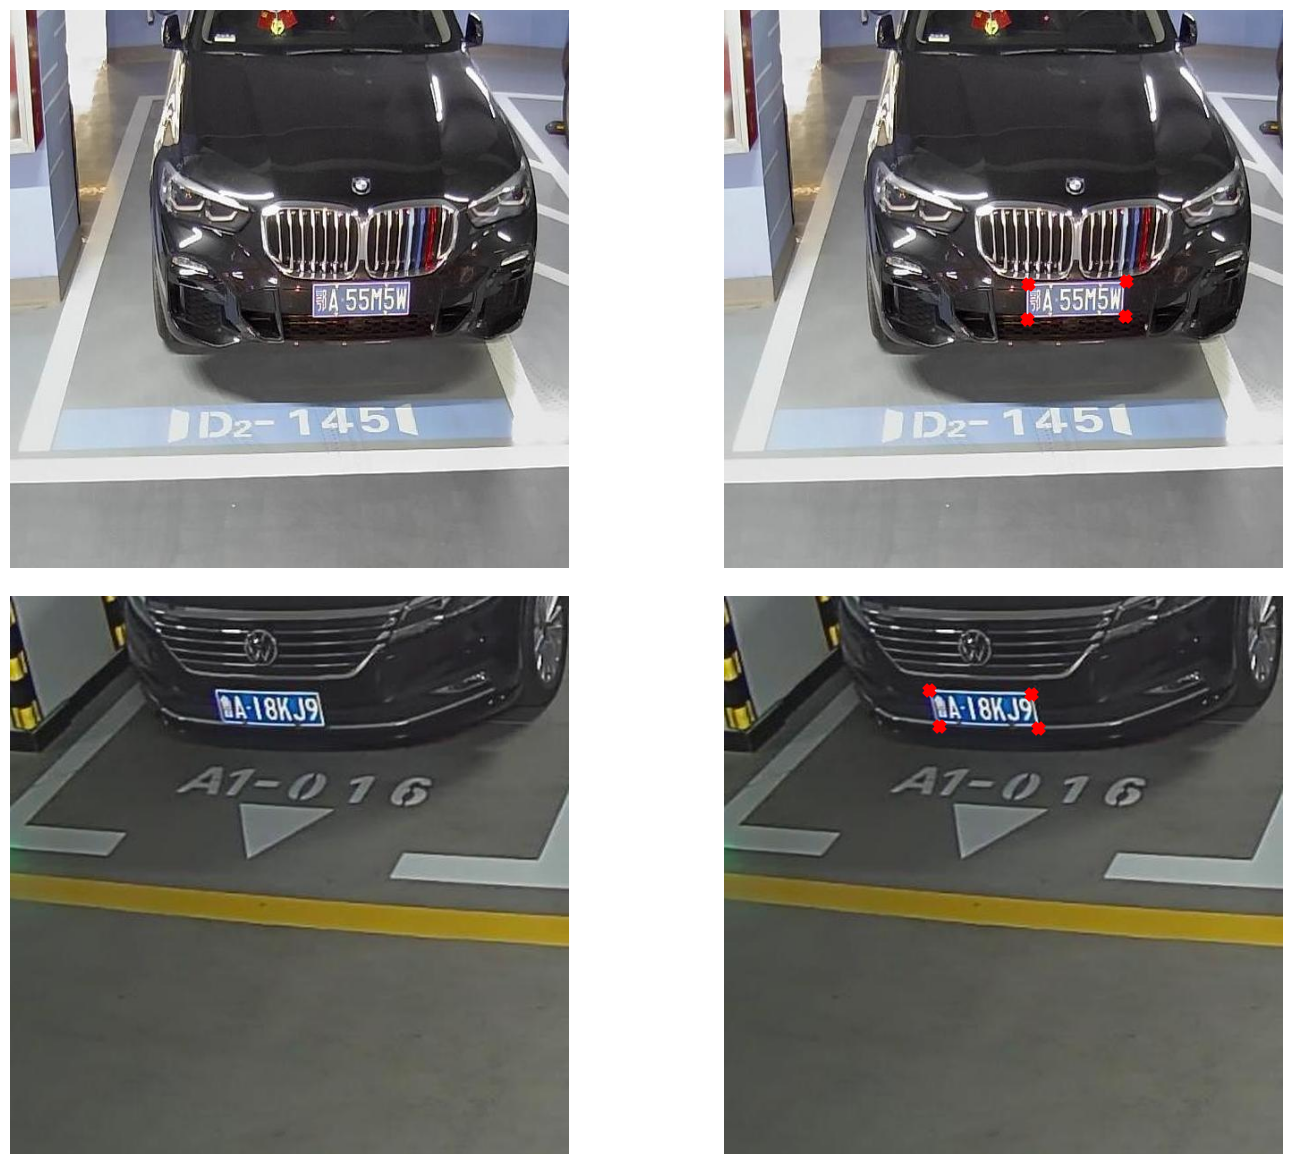

模型预测


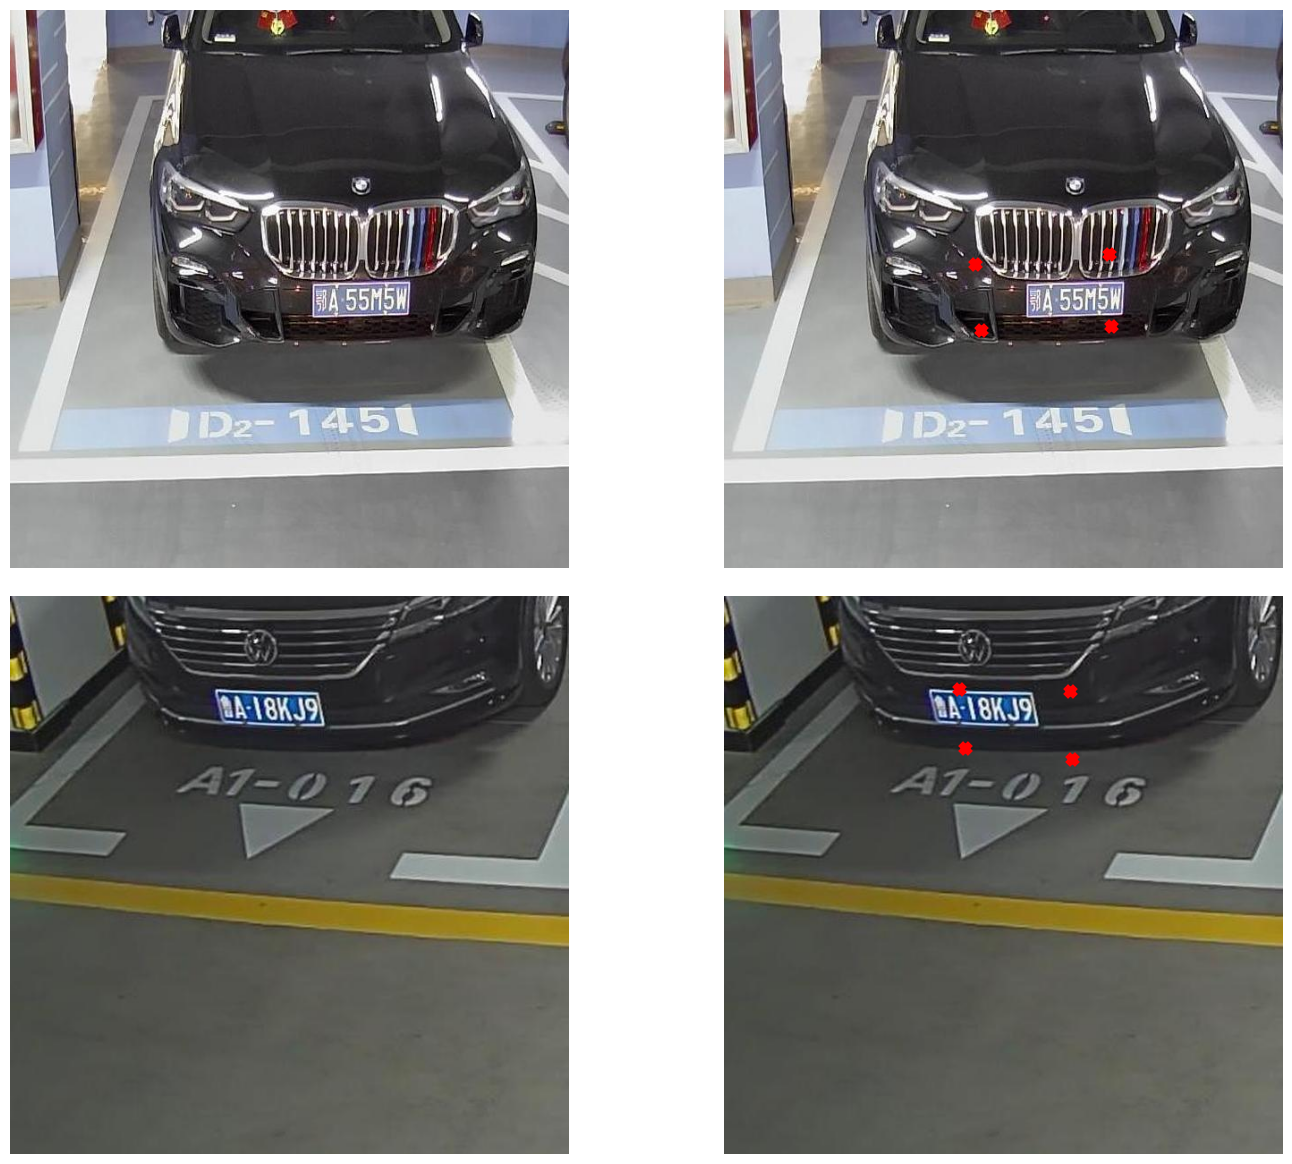

In [16]:
sample_val_images, sample_val_keypoints = next(iter(validation_dataset))
sample_val_images = sample_val_images[:2]
sample_val_keypoints = sample_val_keypoints[:4].reshape(-1, 4, 2) * IMG_SIZE
predictions = model.predict(sample_val_images).reshape(-1, 4, 2) * IMG_SIZE
 
print("实际")
visualize_keypoints(sample_val_images, sample_val_keypoints)

print("模型预测")
visualize_keypoints(sample_val_images, predictions)